# Working with data that doesn't fit in memory

In this notebook we will explore the necessary steps to do an arbitrary computation based on data from a dfs file, without reading the entire file in memory first.

In [1]:

import numpy as np
import dask.array as da
import dask

import mikeio
from mikecore.DfsFileFactory import DfsFileFactory

# 1. Create a function to read a subset of the file
def my_dfs_reader(filename, item, t):
    dfs = DfsFileFactory.DfsGenericOpenEdit(str(filename))
    data = dfs.ReadItemTimeStep(itemNumber = item+1, timestepIndex=t)
    return data.Data

# 2. Turn it into a delayed computation , which is is a pure function and can be cached
reader = dask.delayed(my_dfs_reader,pure=True)

# 3. Get the shape of the data
item = 0
testfile = "../tests/testdata/wind_north_sea.dfsu"
filename = testfile
dfs = mikeio.open(filename)
shape = (dfs.n_elements,)
n_timesteps = dfs.n_timesteps

In [2]:
#4. Create a list of delayed functions
lazy_arrays = [reader(testfile,item,t) for t in range(n_timesteps)]
lazy_arrays[0]

Delayed('my_dfs_reader-2e31704906668678a8a9608472f00ad4')

In [3]:
# 5. Create a list of dask arrays
arrays = [da.from_delayed(a, dtype=np.float32, shape=shape) for a in lazy_arrays]

In [4]:
# 6. Stack the arrays into a single array-like object
stack = da.stack(arrays, axis=0)
stack

dask.array<stack, shape=(6, 958), dtype=float32, chunksize=(1, 958), chunktype=numpy.ndarray>

In [5]:
stack.dtype, stack.ndim, stack.shape

(dtype('float32'), 2, (6, 958))

Calling e.g. `.mean()` on the `stack` only creates a computational graph, it doesn't exectute it.

In [6]:
stack.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

In [7]:
stack.mean(axis=1).compute()

array([10.234554 , 10.264292 , 10.531686 , 10.794677 , 10.858319 ,
       10.9060335], dtype=float32)

As an example of a computation we choose the trimmed mean in each timestep, i.e. ignoring a fraction from the tails (e.g. caused by to numerical instability)
<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.trim_mean.html>

(this still reads the entire dataset, since dask doesn't know how to calculate a trimmed mean?🤔)

In [8]:
from scipy import stats

tm = stats.trim_mean(stack, 0.1, axis=1)
tm

array([10.331429, 10.351207, 10.670218, 10.930687, 11.019432, 11.058955],
      dtype=float32)

## DataArray

Creating a mikeio DataArray with a dask array instead of a NumPy array is possible.

Are there any limitations 🤔?

In [17]:
da = mikeio.DataArray(data=stack, time=dfs.time, geometry=dfs.geometry, item=dfs.items[item])
da

<mikeio.DataArray>
name: Wind speed
dims: (time:6, element:958)
time: 2017-10-27 00:00:00 - 2017-10-27 05:00:00 (6 records)
geometry: Dfsu2D (958 elements, 570 nodes)

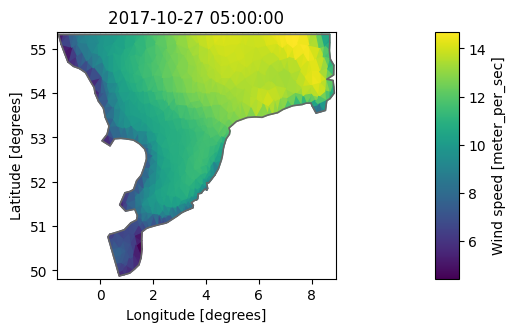

In [20]:
da.isel(time=-1).plot();

In [26]:
mda = da.mean()

In [32]:
mda

TypeError: unsupported format string passed to Array.__format__

In [27]:
type(mda)

mikeio.dataarray.DataArray

In [28]:
type(mda.values)

dask.array.core.Array

In [30]:
mda.values.compute()

array([10.364221 ,  9.923343 , 10.065123 ,  9.613399 , 11.170132 ,
       13.088929 , 10.176351 , 13.406188 , 10.309226 , 11.316236 ,
       12.124619 , 12.103238 , 10.555797 , 10.396169 , 11.787071 ,
       10.658889 ,  8.821848 , 11.0115385,  4.7177215,  6.173535 ,
        5.103184 ,  6.3007073, 12.529544 ,  7.650946 ,  5.821486 ,
       10.083186 ,  8.384222 , 14.019547 ,  5.5536733, 11.865041 ,
        6.7281895, 13.341821 ,  5.007231 ,  5.6754813,  5.7009964,
        8.482699 , 12.8366785,  6.151703 ,  6.8178744, 13.67719  ,
        6.6221366,  8.69757  , 10.583645 , 12.480821 , 13.337848 ,
        9.774634 , 12.391949 , 13.006325 , 10.430568 , 11.5022   ,
       10.297248 , 12.098232 , 13.485686 , 13.352249 , 11.334523 ,
       13.481868 , 11.804993 , 13.168241 , 13.479293 , 12.823176 ,
        5.840704 , 11.725774 , 13.78389  ,  5.3381944,  5.590835 ,
       13.140911 , 13.423068 ,  6.6157455, 10.520663 , 10.383477 ,
        6.9204917, 13.292895 , 13.939855 ,  6.551924 , 10.9684